## NMF of PCP-cleaned Sonar Data

In [11]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from numpy.linalg import inv, eig, pinv
from scipy import linalg
from scipy import pi, multiply, power, tanh, exp, cosh
from scipy import random

In [12]:
from sklearn import decomposition as decomp
import nimfa

In [14]:
sys.path.insert(0,'..')
import db_diff
import decomp_plot

/home/wu-jung/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
# This is the pcp(Principal Projection Pursuit) function from https://github.com/dfm/pcp

"""
An implementation of the Principal Component Pursuit algorithm for robust PCA
as described in `Candes, Li, Ma, & Wright <http://arxiv.org/abs/0912.3599>`_.
An alternative Python implementation using non-standard dependencies and
different hyperparameter choices is available at:
http://blog.shriphani.com/2013/12/18/
    robust-principal-component-pursuit-background-matrix-recovery/
"""

from __future__ import division, print_function

__all__ = ["pcp"]

import time
# import fbpca
import logging
import numpy as np
from scipy.sparse.linalg import svds


def pcp(M, delta=1e-6, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method="approximate", **svd_args):
    # Check the SVD method.
    allowed_methods = ["approximate", "exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        # step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        if verbose:
            print(("Iteration {0}: error={1:.3e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if err < delta:
            break
        i += 1

    if i >= maxiter:
        logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S


def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "approximate":
        return fbpca.pca(X, k=rank, raw=True, **args)
    elif method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

In [7]:
# Reading 2-month sonar time series
import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),"r")
MVBS = np.array(f['MVBS'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_time = np.array(f['ping_time'])
f.close()

In [8]:
ping_per_day_mvbs = 144

In [9]:
# converting to linear domain
mvbs = 10**(MVBS[:,1:-2,:]/10)  # 62-day stretch
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

### Run Robust PCA and check results

In [10]:
%%time
# applying pcp to the data in log domain (i.e. the way data comes from ooi)
L, S, (u,s,v) = pcp(10*np.log10(mvbs_long),maxiter=500, verbose=False,svd_method="exact")

CPU times: user 19.1 s, sys: 456 ms, total: 19.5 s
Wall time: 4.95 s


In [16]:
L_sep, L_plot = decomp_plot.separate_transform_result(L,mvbs,ping_per_day_mvbs,log_opt = 0)
S_sep, S_plot = decomp_plot.separate_transform_result(S,mvbs,ping_per_day_mvbs,log_opt = 0)

In [71]:
import copy

In [72]:
plot_param_base = dict([("x_ticks_spacing", 5),\
                       ("y_ticks_num",5),\
                       ("y_start_idx",1),\
                       ("y_end_idx",-2),\
                       ("c_min",-80),\
                       ("c_max",-40),\
                       ("c_ticks_spacing",10),\
                       ("ping_per_day_mvbs",ping_per_day_mvbs),\
                       ("depth_bin_size",depth_bin_size),\
                       ("ping_time",ping_time)])

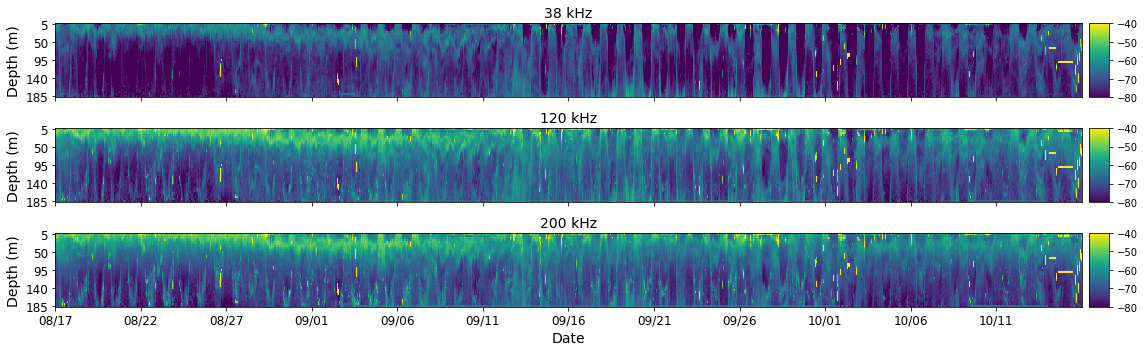

In [100]:
# plotting the raw data
plot_param_raw = copy.deepcopy(plot_param_base)
db_diff.plot_echogram(MVBS,1,60,plot_param_raw,fig_size=(16,5),cmap_name='viridis')

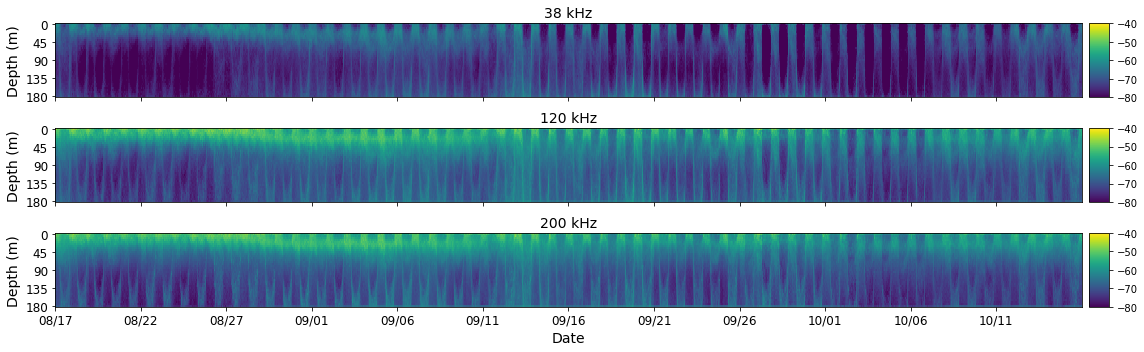

In [101]:
# plotting the low-rank component
plot_param_L = copy.deepcopy(plot_param_base)
plot_param_L["y_start_idx"] = 0
plot_param_L["y_end_idx"] = 0
db_diff.plot_echogram(L_plot,1,60,plot_param_L,fig_size=(16,5),cmap_name='viridis')

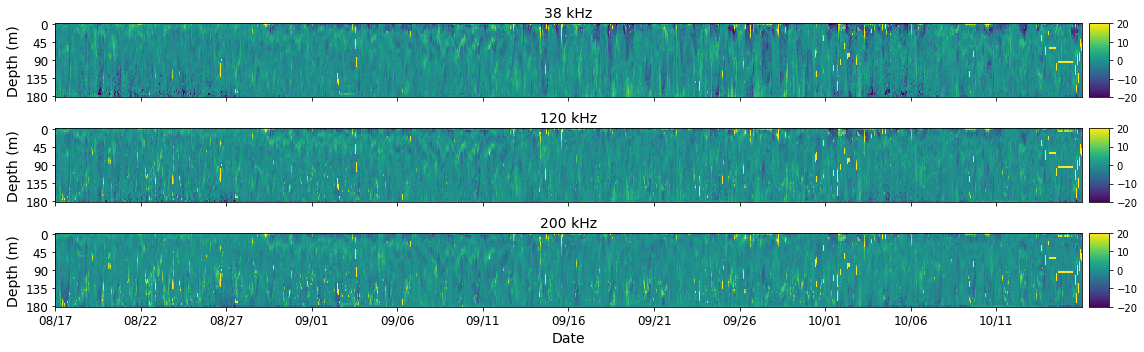

In [102]:
# plotting the sparse component
plot_param_S = copy.deepcopy(plot_param_base)
plot_param_S["y_start_idx"] = 0
plot_param_S["y_end_idx"] = 0
plot_param_S["c_min"] = -20
plot_param_S["c_max"] = 20
db_diff.plot_echogram(S_plot,1,60,plot_param_S,fig_size=(16,5),cmap_name='viridis')

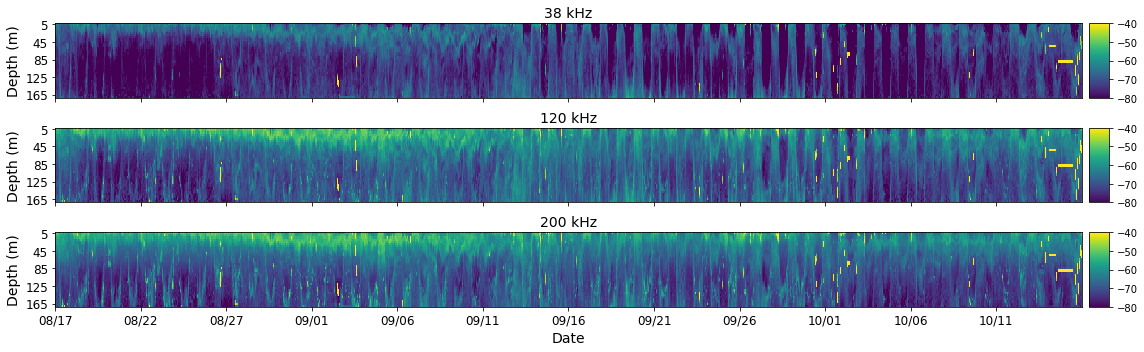

In [103]:
# plotting the reconstruction
plot_param_r = copy.deepcopy(plot_param_base)
db_diff.plot_echogram(S_plot+L_plot,1,60,plot_param_r,fig_size=(16,5),cmap_name='viridis')

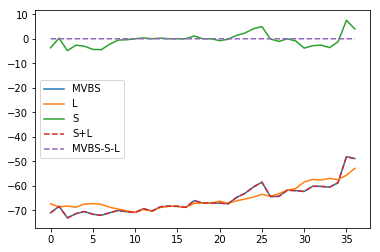

In [92]:
plt.plot(MVBS[1,1:-2,100],label='MVBS')
plt.plot(L_plot[1,:,100],label='L')
plt.plot(S_plot[1,:,100],label='S')
plt.plot(S_plot[1,:,100]+L_plot[1,:,100],'--',label='S+L')
plt.plot(MVBS[1,1:-2,100]-S_plot[1,:,100]-L_plot[1,:,100],'--',label='MVBS-S-L')
plt.legend()

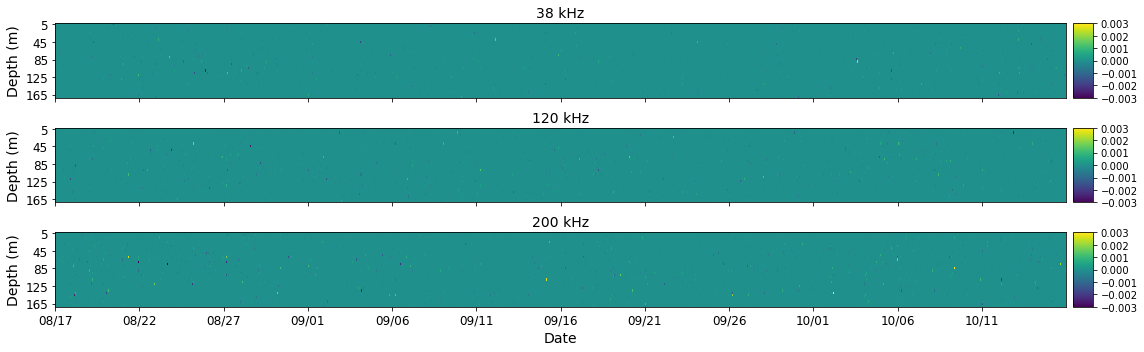

In [104]:
# plotting the reconstruction error
plot_param_e = copy.deepcopy(plot_param_base)
plot_param_e["c_min"] = -0.003
plot_param_e["c_max"] = 0.003
plot_param_e["c_ticks_spacing"] = 0.001
db_diff.plot_echogram(MVBS[:,1:-2,:]-S_plot-L_plot,1,60,plot_param_e,fig_size=(16,5),cmap_name='viridis')

*********************
## Run NMF on low-rank component from robust PCA

### Linear domain

In [124]:
# Run NMF on L component in log domain from pcp
# L and S have the same shape as mvbs_long
# L and S are in the log domain so have to convert to linear domain before running NMF

l = 10**(L.copy()/10)

n_comp = 4
nmf_L = decomp.NMF(n_components=n_comp)
W_L = nmf_L.fit_transform(l)
H_L = nmf_L.components_
V_L = H_L.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_L = nmf_L.inverse_transform(W_L).copy()
D_L_sep,D_L_plot = decomp_plot.separate_transform_result(D_L,mvbs,ping_per_day_mvbs,log_opt=1)

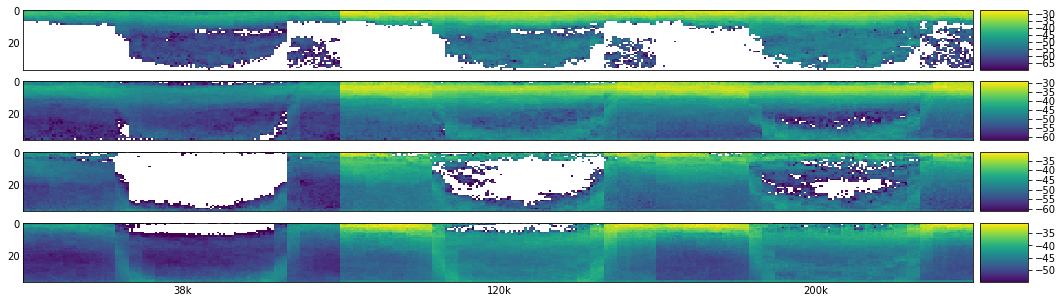

In [144]:
decomp_plot.plot_comp(V_L,n_comp,ping_per_day_mvbs,figsize_input=(18,5),log_opt=1)

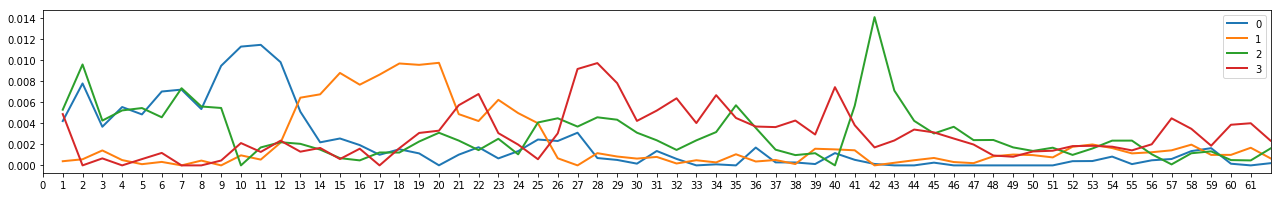

In [131]:
decomp_plot.plot_coef(W_L,n_comp)  # coef in linear scale

### Log domain

In [141]:
# Run NMF on L component in log domain from pcp
# L and S have the same shape as mvbs_long
# L and S are in the log domain so have to convert to linear domain before running NMF

L_pos = L.copy()-L.min()

n_comp = 4
nmf_L_log = decomp.NMF(n_components=n_comp)
W_L_log = nmf_L_log.fit_transform(L_pos)
H_L_log = nmf_L_log.components_
V_L_log = H_L_log.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_L_log = nmf_L_log.inverse_transform(W_L_log).copy()
D_L_log_sep,D_L_log_plot = decomp_plot.separate_transform_result(D_L_log,mvbs,ping_per_day_mvbs,log_opt=1)

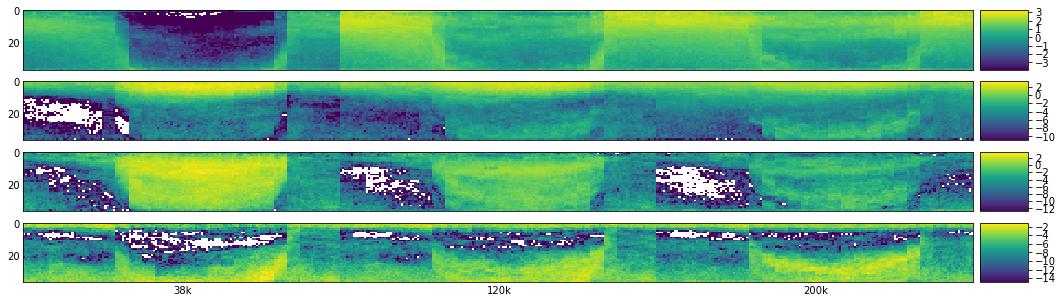

In [142]:
decomp_plot.plot_comp(V_L_log,n_comp,ping_per_day_mvbs,figsize_input=(18,5),log_opt=1)

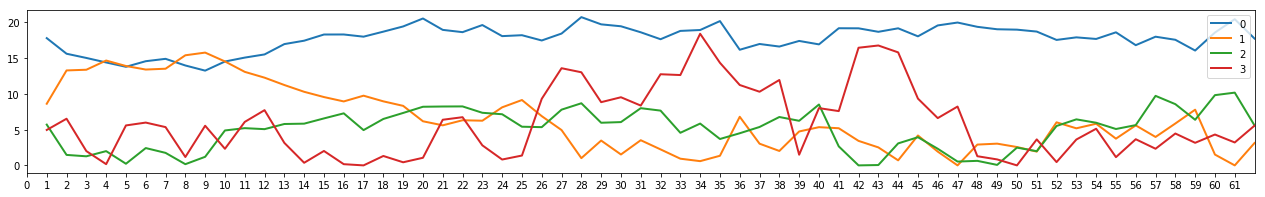

In [143]:
decomp_plot.plot_coef(W_L_log,n_comp)  # coef in linear scale

********************
## Run NMF on sparse component from robust PCA

## Linear domain

In [174]:
# Run NMF on S component in linear domain from pcp
# L and S have the same shape as mvbs_long
# L and S are in the log domain so have to convert to linear domain before running NMF

s = 10**(S.copy()/10)

n_comp = 8
nmf_S = decomp.NMF(n_components=n_comp)
W_S = nmf_S.fit_transform(s)
H_S = nmf_S.components_
V_S = H_S.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_S = nmf_S.inverse_transform(W_S).copy()
D_S_sep,D_S_plot = decomp_plot.separate_transform_result(D_S,mvbs,ping_per_day_mvbs,log_opt=1)

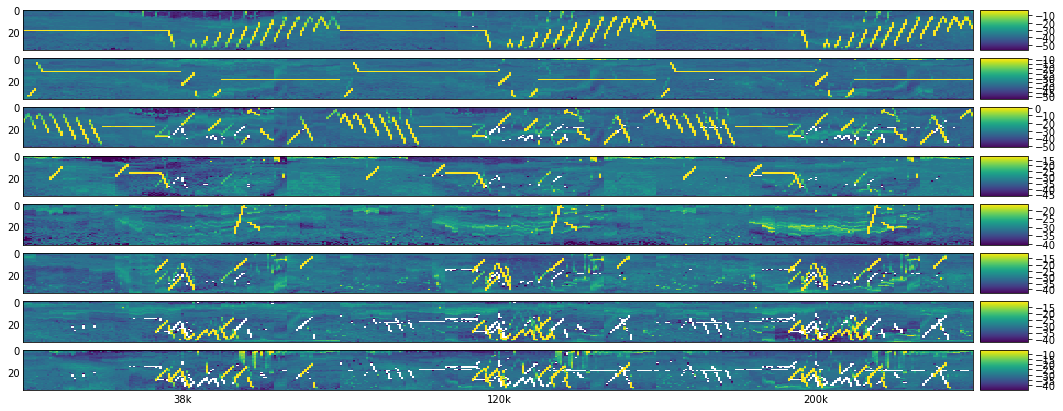

In [175]:
decomp_plot.plot_comp(V_S,n_comp,ping_per_day_mvbs,figsize_input=(18,7),log_opt=1)

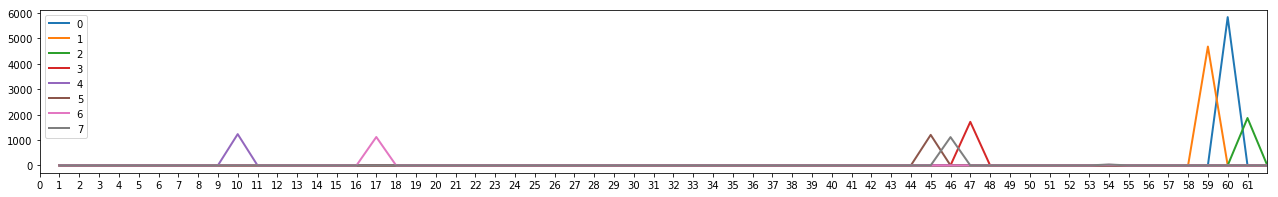

In [176]:
decomp_plot.plot_coef(W_S,n_comp)  # coef in linear scale

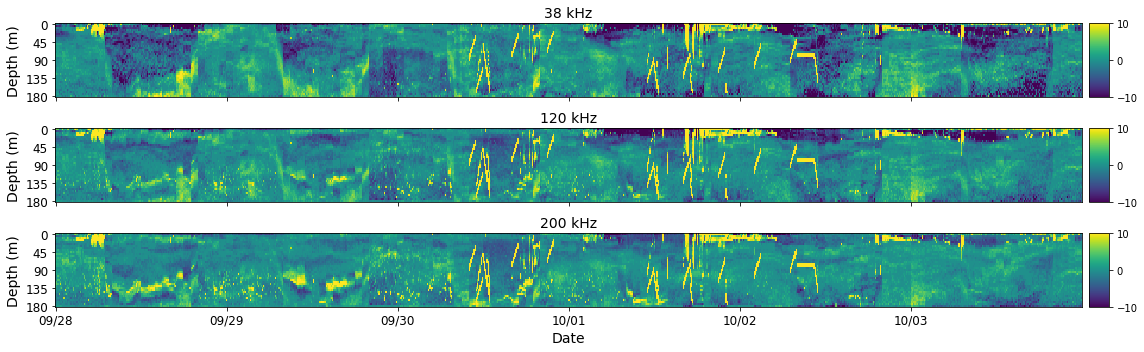

In [182]:
# plotting the sparse component
plot_param_ch = copy.deepcopy(plot_param_base)
plot_param_ch["x_ticks_spacing"] = 1
plot_param_ch["y_start_idx"] = 0
plot_param_ch["y_end_idx"] = 0
plot_param_ch["c_min"] = -10
plot_param_ch["c_max"] = 10
db_diff.plot_echogram(S_plot,43,6,plot_param_ch,fig_size=(16,5),cmap_name='viridis')

*************************
## PCP on section of sonar data without strong profiler echoes

In [161]:
# converting to linear domain
mvbs_sub = 10**(MVBS[:,1:-2,19*ping_per_day_mvbs:26*ping_per_day_mvbs]/10)  # take day 20-36 when there were less profiler echoes
mvbs_sub_3freq = np.array([mvbs_sub[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs_sub.shape[1])) for ff in range(3)])
mvbs_sub_long = mvbs_sub_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs_sub.shape[1]*3))

In [162]:
%%time
# applying pcp to the data in log domain (i.e. the way data comes from ooi)
L_sub, S_sub, (u_sub,s_sub,v_sub) = pcp(10*np.log10(mvbs_sub_long),maxiter=500, verbose=False,svd_method="exact")

CPU times: user 4.25 s, sys: 12 ms, total: 4.26 s
Wall time: 1.07 s


In [163]:
L_sub_sep, L_sub_plot = decomp_plot.separate_transform_result(L_sub,mvbs,ping_per_day_mvbs,log_opt = 0)
S_sub_sep, S_sub_plot = decomp_plot.separate_transform_result(S_sub,mvbs,ping_per_day_mvbs,log_opt = 0)

In [164]:
MVBS_sub = 10*np.log10(mvbs_sub)

In [165]:
plot_param_base = dict([("x_ticks_spacing", 5),\
                       ("y_ticks_num",5),\
                       ("y_start_idx",1),\
                       ("y_end_idx",-2),\
                       ("c_min",-80),\
                       ("c_max",-40),\
                       ("c_ticks_spacing",10),\
                       ("ping_per_day_mvbs",ping_per_day_mvbs),\
                       ("depth_bin_size",depth_bin_size),\
                       ("ping_time",ping_time)])

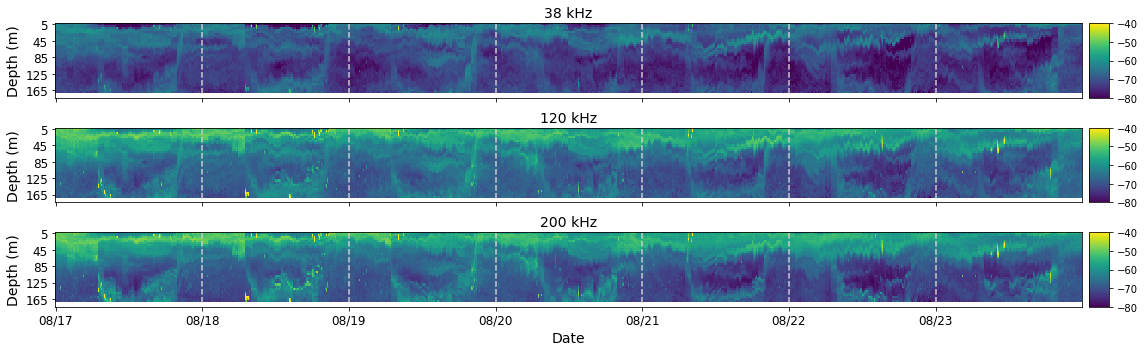

In [221]:
# plotting the raw data
plot_param_raw = copy.deepcopy(plot_param_base)
plot_param_raw["x_ticks_spacing"] = 1
db_diff.plot_echogram(MVBS_sub,1,7,plot_param_raw,fig_size=(16,5),cmap_name='viridis')

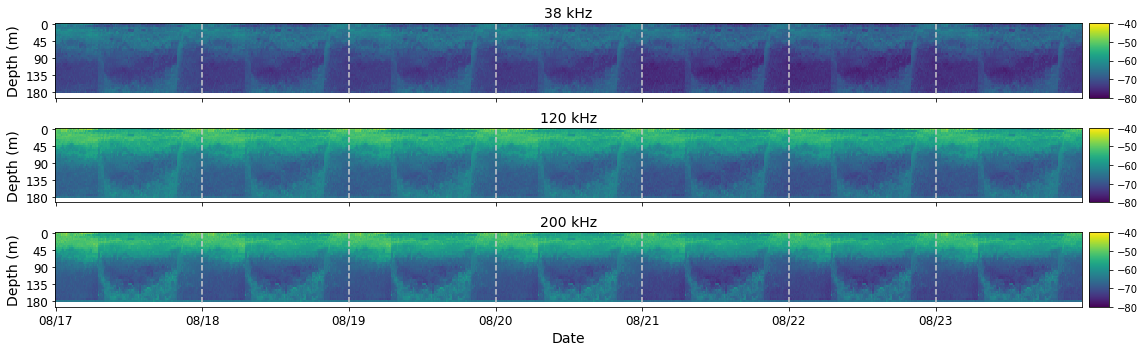

In [222]:
# plotting the low-rank component
plot_param_L = copy.deepcopy(plot_param_base)
plot_param_L["y_start_idx"] = 0
plot_param_L["y_end_idx"] = 0
plot_param_L["x_ticks_spacing"] = 1
db_diff.plot_echogram(L_sub_plot,1,7,plot_param_L,fig_size=(16,5),cmap_name='viridis')

In [216]:
reload(db_diff)

<module 'db_diff' from '../db_diff.py'>

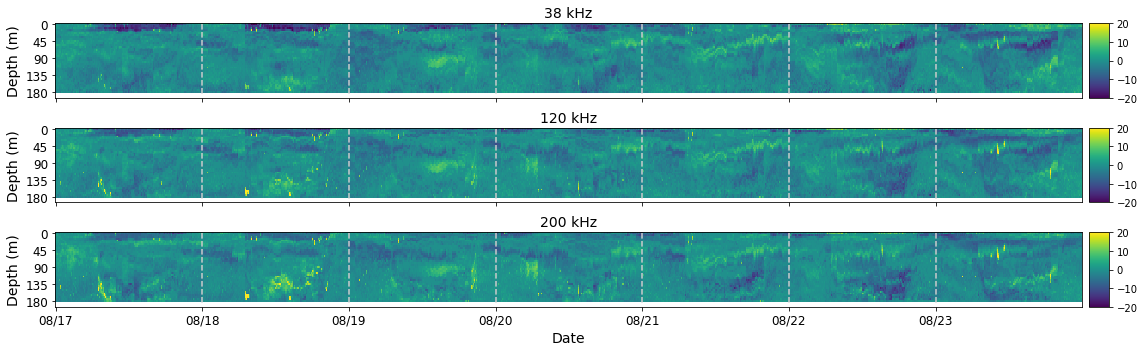

In [218]:
# plotting the sparse component
plot_param_S = copy.deepcopy(plot_param_base)
plot_param_S["y_start_idx"] = 0
plot_param_S["y_end_idx"] = 0
plot_param_S["c_min"] = -20
plot_param_S["c_max"] = 20
plot_param_S["x_ticks_spacing"] = 1
db_diff.plot_echogram(S_sub_plot,1,7,plot_param_S,fig_size=(16,5),cmap_name='viridis')

In [188]:
s_sub = 10**(S_sub.copy()/10)

n_comp = 3
nmf_S_sub = decomp.NMF(n_components=n_comp)
W_S_sub = nmf_S_sub.fit_transform(s_sub)
H_S_sub = nmf_S_sub.components_
V_S_sub = H_S_sub.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

D_S_sub = nmf_S_sub.inverse_transform(W_S_sub).copy()
D_S_sub_sep,D_S_sub_plot = decomp_plot.separate_transform_result(D_S_sub,mvbs,ping_per_day_mvbs,log_opt=1)

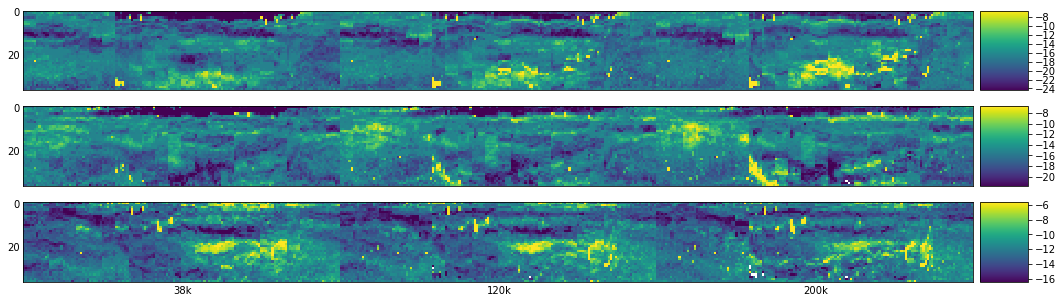

In [191]:
decomp_plot.plot_comp(V_S_sub,n_comp,ping_per_day_mvbs,figsize_input=(18,5),log_opt=1)

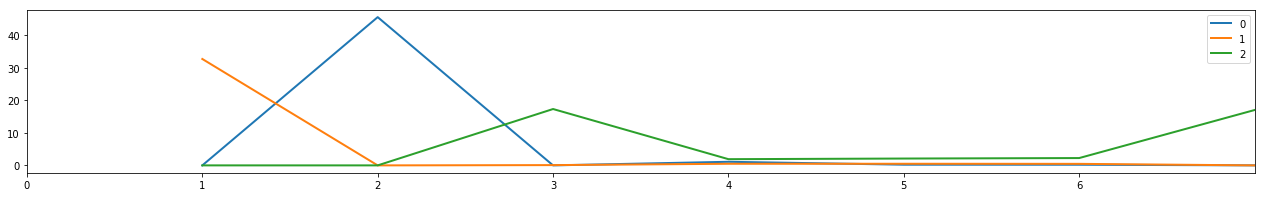

In [190]:
decomp_plot.plot_coef(W_S_sub,n_comp)  # coef in linear scale